# Introduction to Reinforcement Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## (Extra: setting up abstract classes)

For some extra Python practice, we create abstract classes for environments and agents (if you're new to Python, you can just run these cells without going into the details).

In [2]:
class AbstractEnvironment:
    '''Base class for all enviornments.'''
    
    def reset(self):
        '''Reset the state of the environment to original.
        
        Returns:
        The new state
        '''
        raise NotImplementedError
        
    def step(self, action):
        '''Run the enivornment one step by taking an action.
        
        Arguments:
        action - The action to take
        
        Returns:
        The amount of reward recieved
        '''
        raise NotImplementedError
    
    def get_current_state(self):
        '''Get the current state of the environment.'''
        raise NotImplementedError
        
    def get_state_space(self):
        '''Get the possible states of the environment'''
        raise NotImplementedError
        
    def get_action_space(self):
        '''Get the possible actions in the environment'''
        raise NotImplementedError

In [3]:
class AbstractAgent:
    '''Abstract class for all agents. '''
    
    def __init__(self, env):
        self.env = env
    
    def step(self):
        '''Take an action '''
        raise NotImplementedError

## A simple two-armed bandit task

We first create a very simple environment: the two-armed bandit. There is no state, and only two actions: left (arm) and right (arm). The two arms give rewards with differnt probability, and the job of the agent if to find the arm that gives most rewards. Technically, we make this class a subclass of the `AbstractEnvironment`.



Two armed bandit

In [5]:
class TwoArmedBanditFixed(AbstractEnvironment):
    
    def __init__(self, left_prob=0.2, right_prob=0.8):
        self.left_prob = left_prob
        self.right_prob = right_prob
        
    def step(self, action):
        #The probability of reward is different for left and right
        if action == 'L':
            reward_prob = self.left_prob
        elif action == 'R':
            reward_prob = self.right_prob
        else:
            raise ValueError(f"Unknown action '{action}', please choose 'L' or 'R'.")
            
        #Test if a reward is actually delivered
        if np.random.random() < reward_prob:
            reward = 1
        else:
            reward = 0            
        return reward
    
    def get_action_space(self):
        return ['L', 'R']

Next, we need an agent that can solve this environment. We create a simple Q-learning agent which uses a logistic (log-odds) decision function.

In [6]:
class SimpleQLearner(AbstractAgent):
    def __init__(self, env, alpha=0.02, beta=1):
        super().__init__(env)
        self.alpha = alpha
        self.beta = beta
        self.Q_L = 0.0
        self.Q_R = 0.0
        
    def step(self):
        left_log_odds = self.beta*(self.Q_L - self.Q_R)
        left_prob = 1/(1+np.exp(-left_log_odds))
        if np.random.random() < left_prob:
            action = 'L'
            reward = self.env.step(action)
            rpe = reward - self.Q_L
            self.Q_L += self.alpha * rpe
        else:
            action = 'R'
            reward = self.env.step(action)
            rpe = reward - self.Q_R
            self.Q_R += self.alpha * rpe
        return action, reward

Alright, let's test this learner.

In [7]:
#First, we create the environment
bandit_env = TwoArmedBanditFixed()

alpha = 0.5
beta = 0

#Then, we create the agent and pass it the environment
agent = SimpleQLearner(bandit_env, alpha, beta)

#How many trials to run
n_trials = 500

#For later plotting, we'll record the actions, Q values and rewards
actions = []
Q_Ls = []
Q_Rs = []
rewards = []


for trial in range(n_trials):
    #Log the Q-values before taking the action
    Q_Ls.append(agent.Q_L)
    Q_Rs.append(agent.Q_R)
    
    #Choose an action and apply it to the environment
    action, reward = agent.step()
    
    #Log the action and the amount of reward recieved
    actions.append(action)
    rewards.append(reward)

First, let's plot the action values `Q_L` and `Q_R`. They should converge to $\mathbb{E}[R_L]$ and $\mathbb{E}[R_R]$ respectively.

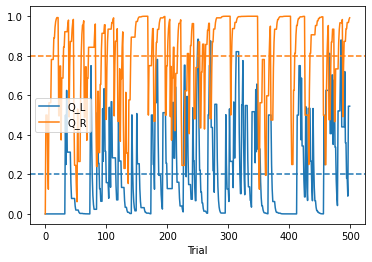

In [8]:
plt.plot(Q_Ls, label="Q_L")
plt.axhline(bandit_env.left_prob, color="C0", linestyle="--")
plt.plot(Q_Rs, label="Q_R")
plt.axhline(bandit_env.right_prob, color="C1", linestyle="--")
plt.xlabel("Trial")
plt.legend()

Let's try to plot the actions. We can use a scatter plot to show which of the two actions to take...

(-2.0, 3.0)

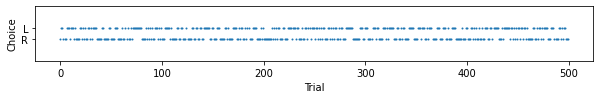

In [9]:
plt.figure(figsize=(10, 1))
plt.scatter(np.arange(n_trials), actions, s=1)
plt.ylabel("Choice")
plt.xlabel("Trial")
plt.ylim(-2,3)

... but it is quite difficult to read. Instead, let's calulate the fraction of `L` and `R` choices in a moving window (extra python exercise: figure out how this method works).

In [10]:
def moving_average(values, window_size):
    cuml = np.cumsum(values)
    ma = cuml[window_size:] - cuml[:-window_size]
    return ma / window_size

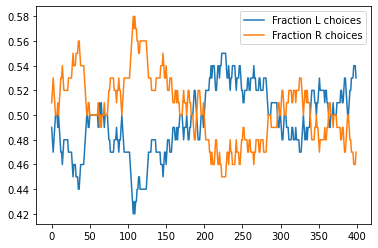

In [11]:
plt.plot(moving_average(np.array(actions)=='L', 100), label="Fraction L choices")
plt.plot(moving_average(np.array(actions)=='R', 100), label="Fraction R choices")
plt.legend()

We can of course also look at the total amount of reward recieved.

In [12]:
print(np.sum(rewards))

257


 How much reward would you expect a completely random agent (that doesn't learn anything) to get?

### Exercise
Play with the parameters `alpha` (learning rate) and `beta` (explore-exploit trade-off) above. What happens with too small `alpha`? Too big? Same question for `beta`: what happens when beta is too small or too large?

## Extending the two armed bandit

We can add one more feature to our two armed bandit: after each trial, there is a small (say, 1%) probability of the reward contingencies being switched. This makes exploration more important even for well-trained agents (why?).

In [ ]:
class TwoArmedBanditSwitching(AbstractEnvironment):
    
    def __init__(self, left_prob=0.2, right_prob=0.8, switch_prob=0.01):
        self.left_prob = left_prob
        self.right_prob = right_prob
        self.switch_prob = switch_prob
        
    def step(self, action):
        #The probability of reward is different for left and right
        if action == 'L':
            reward_prob = self.left_prob
        elif action == 'R':
            reward_prob = self.right_prob
        else:
            raise ValueError(f"Unknown action '{action}', please choose 'L' or 'R'.")
            
        #Test if a reward is actually delivered
        if np.random.random() < reward_prob:
            reward = 1
        else:
            reward = 0
            
        if np.random.random() < self.switch_prob:
            #Switch the probabilities
            self.left_prob, self.right_prob = self.right_prob, self.left_prob
        return reward
    
    def get_action_space(self):
        return ['L', 'R']

Let's be lazy and copy the run code above, but change to the switching environment. We also need to logg the probabilities of the environment so we can plot them later.

In [ ]:
#First, we create the environment
bandit_env = TwoArmedBanditSwitching()

alpha = 0.02
beta = 1.0

#Then, we create the agent and pass it the environment
agent = SimpleQLearner(bandit_env, alpha, beta)

#How many trials to run
n_trials = 500

#For later plotting, we'll record the actions, Q values and rewards
actions = []
Q_Ls = []
Q_Rs = []
left_probs = []
right_probs = []
rewards = []


for trial in range(n_trials):
    #Log the Q-values before taking the action
    Q_Ls.append(agent.Q_L)
    Q_Rs.append(agent.Q_R)
    left_probs.append(bandit_env.left_prob)
    right_probs.append(bandit_env.right_prob)
    
    #Choose an action and apply it to the environment
    action, reward = agent.step()
    
    #Log the action and the amount of reward recieved
    actions.append(action)
    rewards.append(reward)

In [ ]:
plt.plot(Q_Ls, label="Q_L")
plt.plot(left_probs, color="C0", linestyle="--")
plt.plot(Q_Rs, label="Q_R")
plt.plot(right_probs, color="C1", linestyle="--")
plt.xlabel("Trial")
plt.legend()

Total amount of reward:

In [ ]:
print(np.sum(rewards))

### Exercise
Does this change in the environment mean you should change the parameters `alpha` and `beta` of the agent? If so, how? How high total reward can you get? Is there any other way you might want to change the agent?

# Full reinforcement learning

The bandit environments are good at illustrating basic learning, and the explore-exploit problem. But a big limiation is that there is only a single _state_. Much of the theory about reinforcement learning is how to learn a proper policy in environments with multiple (perhaps even infinite!) states. So let's create a small environment with a few different states: a grid-world maze.

In [ ]:
class GridMaze(AbstractEnvironment):
    
    default_maze = ["....G",
                    ".###.",
                    ".....",
                    "...##",
                    "....A"]
    action_movements = {
        'N': np.array((-1, 0)),
        'W': np.array(( 0,-1)),
        'S': np.array(( 1, 0)),
        'E': np.array(( 0, 1)),
    }
    
    def __init__(self, maze=None):
        if maze is None:
            self.maze = self.default_maze.copy()
        #Hack to convert the maze into a numpy array
        self.maze = np.array(list(map(list, self.maze)))
        self.reset()
            
    def reset(self):
        #To reset the environment, we move the agent back to the start.
        self.agent_pos = np.argwhere(self.maze=="A")[0]
        
    def step(self, action):
        if action not in self.action_movements.keys():
            raise ValueError(f"Invalid action {action}. Please use N, W, S or E.")
        movement = self.action_movements[action]
        new_pos = self.agent_pos + movement
        
        #Stop at borders
        new_pos = np.clip(new_pos, [0, 0], np.array(self.maze.shape)-1)
        
        #Stop at obstacles
        new_pos_char = self.maze[tuple(new_pos)]
        if new_pos_char == "#":
            new_pos = self.agent_pos
        self.agent_pos = new_pos
        
        #Was there a reward? 
        if new_pos_char == "G":
            reward = 1
            self.reset() #If so, reset the agent to the start.
        else:
            reward = 0
        
        return reward
    
    def get_current_state(self):
        return tuple(self.agent_pos)
    
    def get_state_space(self):
        return list(np.ndindex(maze_env.maze.shape))
    
    def get_action_space(self):
        return list(self.action_movements.keys())
    
    def render(self):
        '''Plot the maze with the agent.'''
        fig, ax = plt.subplots(1,1)        
        ax.imshow(self.maze == "#", vmin=0, vmax=1, cmap="Greys")
        h, w = self.maze.shape
        ax.plot([-0.5,-0.5,w-0.5,w-0.5,-0.5],
                [-0.5,h-0.5,h-0.5,-0.5,-0.5], 'k', lw=3)
        y, x = self.agent_pos
        self.agent_dot, = plt.plot((x,), (y,), 'ro', ms=20)
        rew_y, rew_x = np.where(self.maze=="G")
        ax.plot(rew_x, rew_y, "b*", ms=30)
        return fig


Next, we implement the SARSA agent. Remember, SARSA stands for State-Action-Reward-State-Action. This comes from the update rule, which is
$$Q(S_{t-1}, A_{t-1}) \leftarrow Q(S_{t-1}, A_{t-1}) + \alpha \cdot \text{RPE}_{t-1} $$
where
$$RPE_{t-1} = R_{t-1} + \gamma Q(S_t, A_t)$$
where $\alpha$ is the learning rate and $\gamma$ is the _discount factor_.

Also, nNow that we have four actions (`N`, `W`, `S` and `E`), we use a softmax to get the action probabilities from the Q-values:
$$ P(A | S) = \frac{e^{\beta Q(S, A)}}{\sum_a e^{\beta Q(S, a)}} $$

In [ ]:
class SARSA(AbstractAgent):
    
    def __init__(self, env, alpha=0.1, beta=5.0, gamma=0.9):
        super().__init__(env)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.action_values = {}
        #For each state-action pair, start the value at 0
        for state in env.get_state_space():
            for action in env.get_action_space():
                self.action_values[(state, action)] = 0.0
        self.prev_state_action = None
        self.prev_reward = None
        
    def step(self):
        #Get the current state of the environment
        state = self.env.get_current_state()
        
        #Get the action values for the actions at this state
        Qs = [self.action_values[(state, A)] for A in self.env.get_action_space()]
        
        #Calculate the so-called softmax of the action values
        Qs = np.array(Qs) / (np.sum(Qs) + 1e-10)
        action_probs  = np.exp(self.beta*np.array(Qs))
        action_probs /= action_probs.sum()
        
        #Pick an action randomly according to the probabilities
        action = np.random.choice(self.env.get_action_space(),
                                  p=action_probs)
        
        #Take the action
        reward = self.env.step(action)
        
        #Update the _previous_ state-action pair using the SARSA rule
        if self.prev_state_action is not None:
            prev_action_value = self.action_values[self.prev_state_action]
            target_action_value = self.prev_reward + self.gamma*self.action_values[(state, action)]
            rpe = target_action_value - prev_action_value
            self.action_values[self.prev_state_action] += self.alpha * rpe
            
        #Save the state-action pair for the next step
        self.prev_state_action = (state, action)
        self.prev_reward = reward
        return action, reward

With this more complicated environment and actor, it is also convenient to define a class that takes care of running and logging the actions.

In [ ]:
import matplotlib.animation
import IPython.display

In [ ]:
class RLRunner:
    
    def __init__(self, agent):
        self.agent = agent
        self.states = []
        self.actions = []
        self.rewards = []
        
    def step(self):
        self.states.append(self.agent.env.get_current_state())
        action, reward = self.agent.step()
        self.actions.append(action)
        self.rewards.append(reward)
        
    def run(self, n_steps):
        for step in range(n_steps):
            self.step()
            
    def plot_cumulative_rewards(self):
        fig, ax = plt.subplots(1,1)
        ax.plot(np.cumsum(self.rewards))
        ax.set_xlabel("Step")
        ax.set_ylabel("Rewards (cuml)")
        
    def plot_reward_rate(self, window_size=100):
        fig, ax = plt.subplots(1,1)
        ax.plot(moving_average(self.rewards, window_size))
        ax.set_xlabel("Step")
        ax.set_ylabel("Reward/step")
        
    def plot_max_value_per_state(self):
        env = self.agent.env
        val_map = np.zeros(env.maze.shape)
        for S in env.get_state_space():
            val_map[S] = np.max([self.agent.action_values[(S, A)]
                                 for A in env.get_action_space()])
        fig, ax = plt.subplots(1, 1)
        im = ax.imshow(val_map)
        plt.colorbar(im, ax=ax, label="max_A Q(S, A)")
        
    def animate_history(self, fps=20, frames=None):
        if frames is None:
            frames = len(self.states)
        fig = self.agent.env.render()
        def anim_update(i):
            y, x = self.states[i]
            self.agent.env.agent_dot.set_data((x,), (y,))
        anim = matplotlib.animation.FuncAnimation(fig, anim_update,
                                                   frames=frames,
                                                   interval=1000.0/fps)
        video = anim.to_html5_video()
        plt.close(fig)
        return IPython.display.HTML(video)

Alright, that was lots of code! But now we're ready to create the agent and the environment...

In [ ]:
maze_env = GridMaze()
sarsa = SARSA(maze_env, beta=10.0)
runner = RLRunner(sarsa)

... and run it!

In [ ]:
runner.run(2000)

Alright, so did it work? Let's look at the cumulative rewards

In [ ]:
runner.plot_cumulative_rewards()

Another way to show the same data is to show the reward rate in a running average.

In [ ]:
runner.plot_reward_rate()

We can also create a video of the agent learning the maze (creating videos in matplotlib is a bit slow, so this might take a minute or two).

In [ ]:
runner.animate_history()

Finally, we can show the value of the most valuable action (and therefore most likely to be chosen) in each state. Here, we can see the discount factor $\gamma$ in action: the closer the agent gets to the goal, the higher the _discounted future reward_ is.

In [ ]:
runner.plot_max_value_per_state()

### Exercises
1) Play with the paramters `alpha`, `beta` and `gamma`. Which is the most important to fine-tune for making the SARSA agent to learn?

2) Try creating a different (maybe a bit bigger?) maze by passing a `maze` argument when creating the `maze_env`. Use the same format as `default_maze` above. Can the agent solve your maze? Does it need other parameters?

3) (A bit more difficult) Based on the SARSA agent, implement an _off-policy_ Q-learner. That is, change the `Q(S_t, A_t)` term in the learning rule to `\max_a Q(S_t, a)`. Is this better? What do you think the advantage of this rule could be?